In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy as sp


In [2]:
sns.set(rc={'figure.figsize':(24, 13.5)}, font_scale = 2.7)

In [3]:
recovery = pd.read_csv('recovery-data/recovery-data.csv', index_col = 'Time')
telemetry = pd.read_csv('maiden_launch_combined_telemetry.csv', index_col='Time [s]')
combined = recovery.drop_duplicates().sort_index().reset_index()

t_ig = 2280.35
t0 = t_ig-2 # time of start of plot [s]
duration = 35  # flight duration [s]
g = -9.81 # correct for gravity

combined['Time [s]'] = (combined['Time'])/1000 - t_ig
combined['Acceleration 1 [g]'] = (combined['Ay_IMU1'] / g)
combined['Acceleration 2 [g]'] = (combined['Ay_IMU2'] / g)
combined['Temperature [°C]'] = combined['T_SHT']
combined['Humidity [%]'] = combined['H_SHT']
#combined['Battery [V]'] = combined['battery_battery']/1000
combined['Pressure 1 [kPa]'] = combined['P_BARO1']/1000
combined['Pressure 2 [kPa]'] = combined['P_BARO2']/1000

gyro_labels = ['Gx_IMU1','Gy_IMU1','Gz_IMU1','Gx_IMU2','Gy_IMU2','Gz_IMU2']
acc_labels = ['Ax_IMU1','Ay_IMU1','Az_IMU1','Ax_IMU2','Ay_IMU2','Az_IMU2']

for label in gyro_labels:
    combined[label] /= 2
#convert to gs
fmt_acc = lambda x: x / 1024
#convert to degrees per second
fmt_gyro = lambda x: x / 16.4
dim3 = lambda x : [x + '_' + s for s in ['x', 'y', 'z']]

telemetry[dim3('Acceleration')] = telemetry[dim3('sb_data_acc')].apply(pd.to_numeric).apply(fmt_acc)
telemetry[dim3('Gyro')] = telemetry[dim3('sb_data_gyro')].apply(pd.to_numeric).apply(fmt_gyro)

telemetry.index += -1.55
#
combined = combined[combined['Time [s]']>-2].reset_index()
telemetry = telemetry[telemetry.index>-2].reset_index()

# Some options
show_telemetry = True     # whether to display telemetry data points
show_flight_events = True # whether to display ignition, burnout, apogee
show_actuation = True     # whether to display airbrake actuation areas

t_ignition = 0 # time of ignition [s]
t_burnout = 3.85  # time of burnout [s]
t_apogee = combined['Time [s]'][pd.Series.argmin(combined['Pressure 1 [kPa]'])]
0# time of apogee (min pressure) [s]

def plot_events(plt):
    if show_flight_events:
        plt.axvline(x=t_ignition, color='k')
        plt.axvline(x=t_burnout, color='k')
        plt.axvline(x=t_apogee, color='k')
    if show_actuation:
        plt.axvspan(5.4, 5.8, color='b', alpha=0.2)
        plt.axvspan(7.15, 8.2, color='b', alpha=0.2)
        plt.axvspan(9.55, 14.45, color='b', alpha=0.2)
        


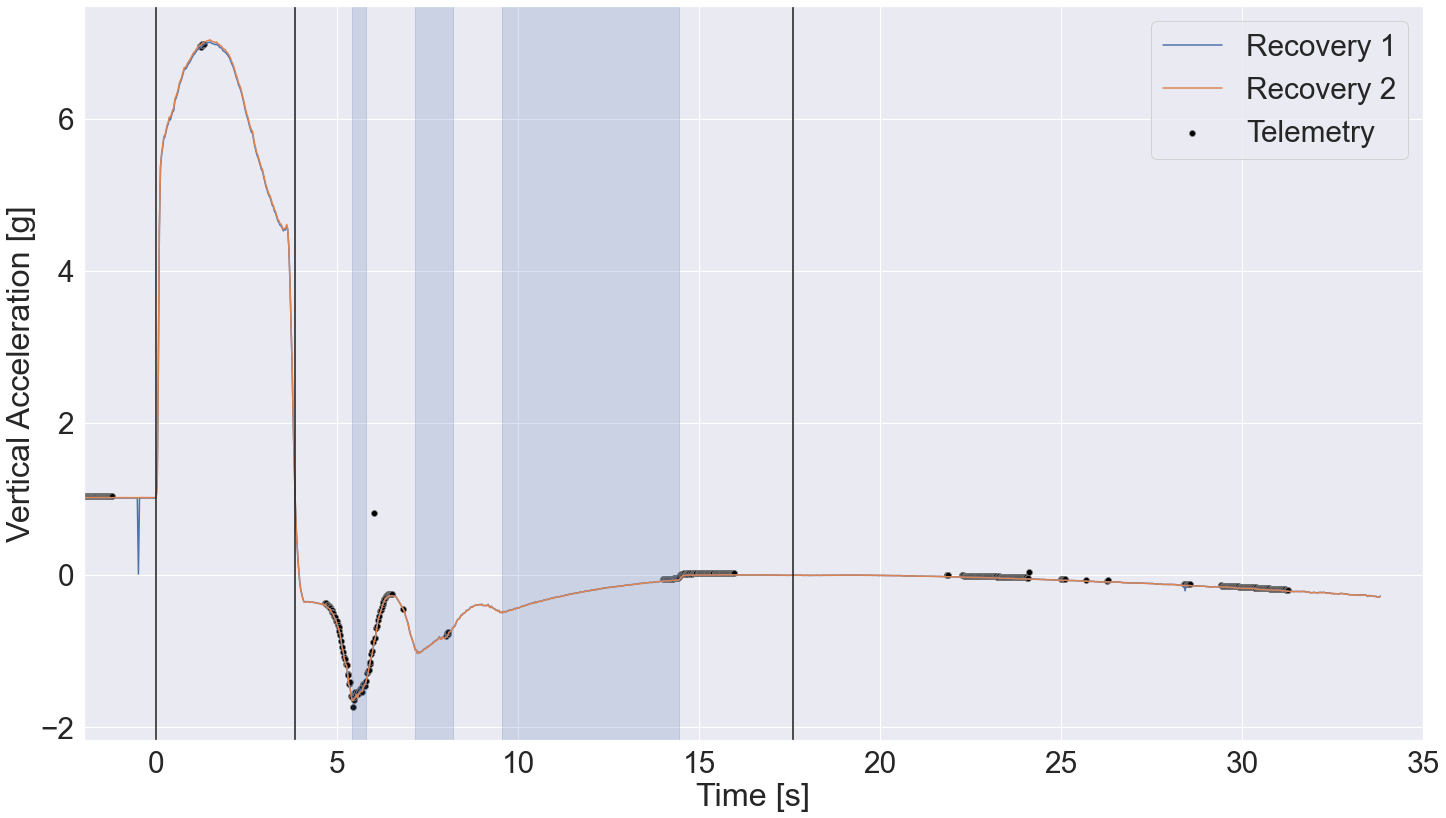

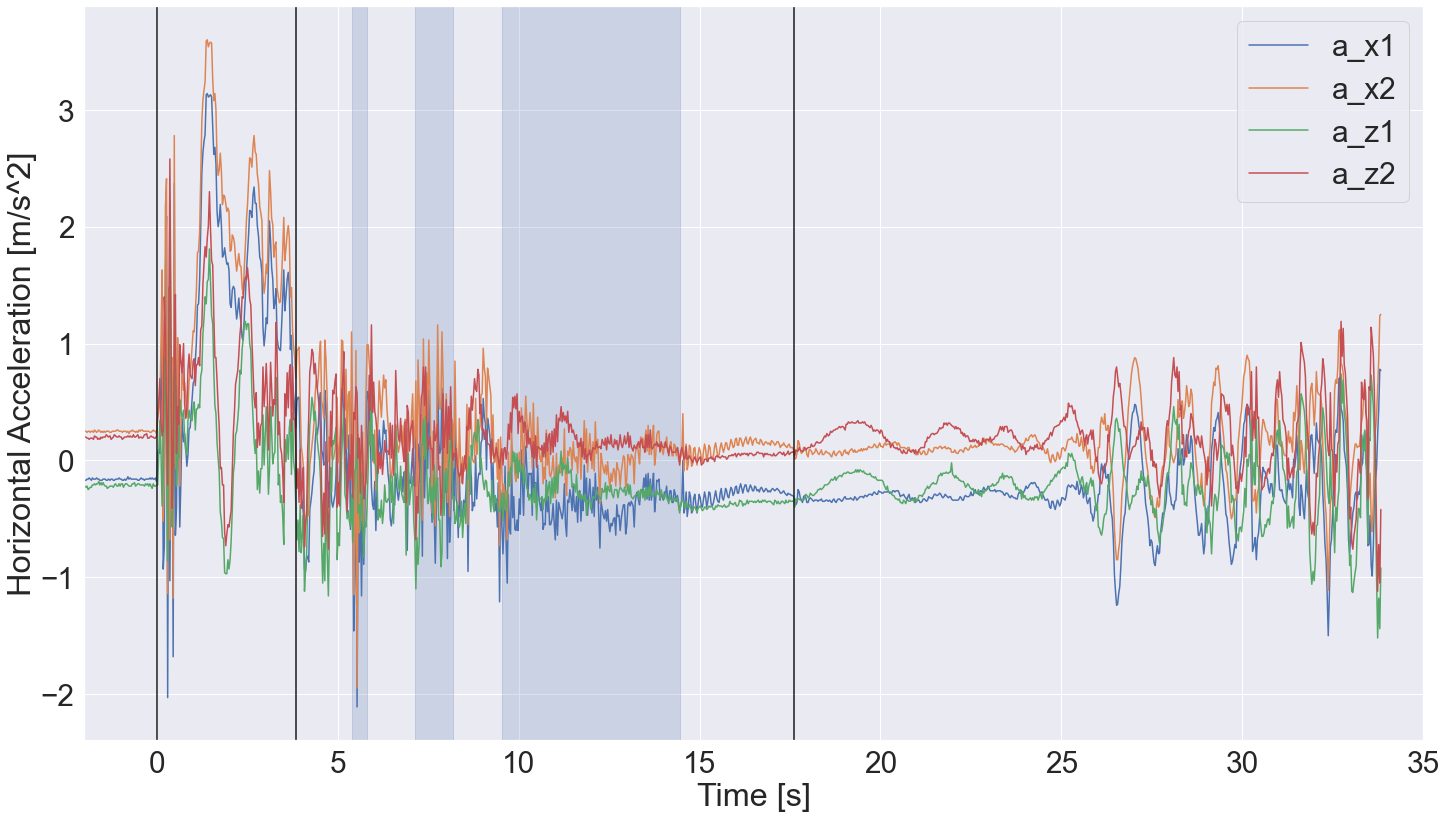

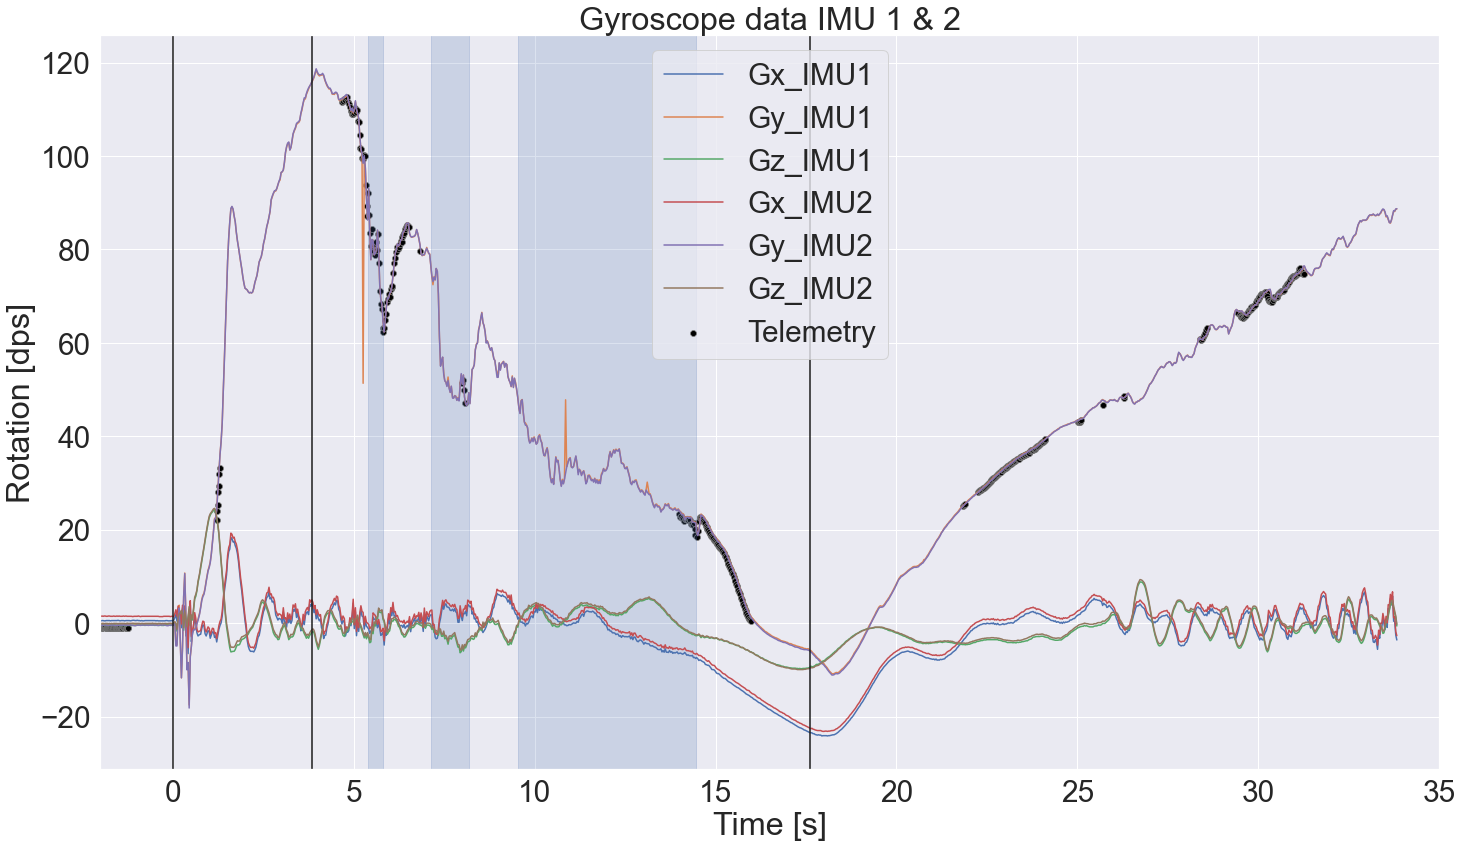

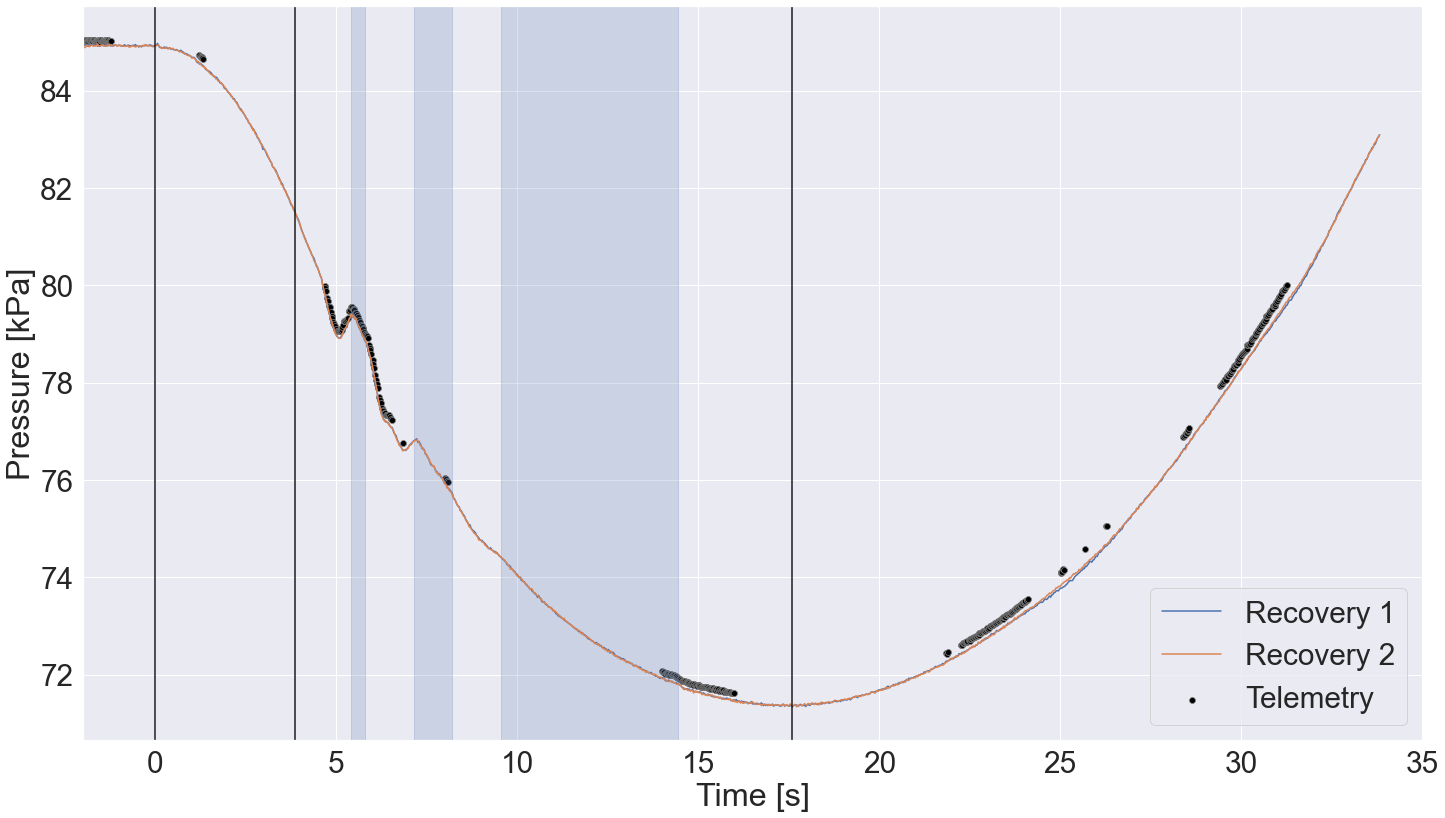

In [4]:
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

# ACC ROLL AXIS PLOT
ax = sns.lineplot(data = combined, x = 'Time [s]', y = 'Acceleration 1 [g]', label="Recovery 1")
ax = sns.lineplot(data = combined, x = 'Time [s]', y = 'Acceleration 2 [g]', label="Recovery 2")

if show_telemetry:
    ax = sns.scatterplot(data = telemetry, x = 'Time [s]', y = 'Acceleration_z', color = 'black', edgecolor='gray', label='Telemetry')

plot_events(plt)

ax.set_ylabel('Vertical Acceleration [g]')
ax.set_xlabel('Time [s]')
ax.set_xlim(-2, duration)

plt.show()

# ACC HORIZONTAL PLOT
ax = sns.lineplot(data = combined, x = 'Time [s]', y = 'Ax_IMU1', label='a_x1')
ax = sns.lineplot(data = combined, x = 'Time [s]', y = 'Ax_IMU2', label='a_x2')
ax = sns.lineplot(data = combined, x = 'Time [s]', y = 'Az_IMU1', label='a_z1')
ax = sns.lineplot(data = combined, x = 'Time [s]', y = 'Az_IMU2', label='a_z2')
plot_events(plt)

ax.set_ylabel('Horizontal Acceleration [m/s^2]')
ax.set_xlabel('Time [s]')
ax.set_xlim(-2, duration)

plt.legend(loc='upper right')
plt.show()


# GYRO PLOT
for label in gyro_labels:
    ax = sns.lineplot(data = combined, x = 'Time [s]', y = label, label=label)

if show_telemetry:
    ax = sns.scatterplot(data = telemetry.reset_index(), x = 'Time [s]', y = 'Gyro_z', color = 'black', edgecolor='gray', label='Telemetry')

plot_events(plt)
ax.set_title(f'Gyroscope data IMU 1 & 2')
ax.set_ylabel('Rotation [dps]')
ax.set_xlabel('Time [s]')
ax.set_xlim(-2, duration)
plt.legend(loc='upper center')
plt.show()

#plt = sns.scatterplot(data = combined.reset_index(), x = 'Time [s]', y = 'Pressure [kPa]', color = 'black', edgecolor='gray')
ax = sns.lineplot(data = combined.reset_index(), x = 'Time [s]', y = 'Pressure 1 [kPa]', label="Recovery 1")
ax = sns.lineplot(data = combined.reset_index(), x = 'Time [s]', y = 'Pressure 2 [kPa]', label="Recovery 2")
plot_events(plt)

if show_telemetry:
    ax = sns.scatterplot(data = telemetry.reset_index(), x = 'Time [s]', y = 'Pressure [kPa]', color = 'black', edgecolor='gray', label='Telemetry')

ax.set_ylabel('Pressure [kPa]')
ax.set_xlabel('Time [s]')
ax.set_xlim(-2, duration)
plt.show()



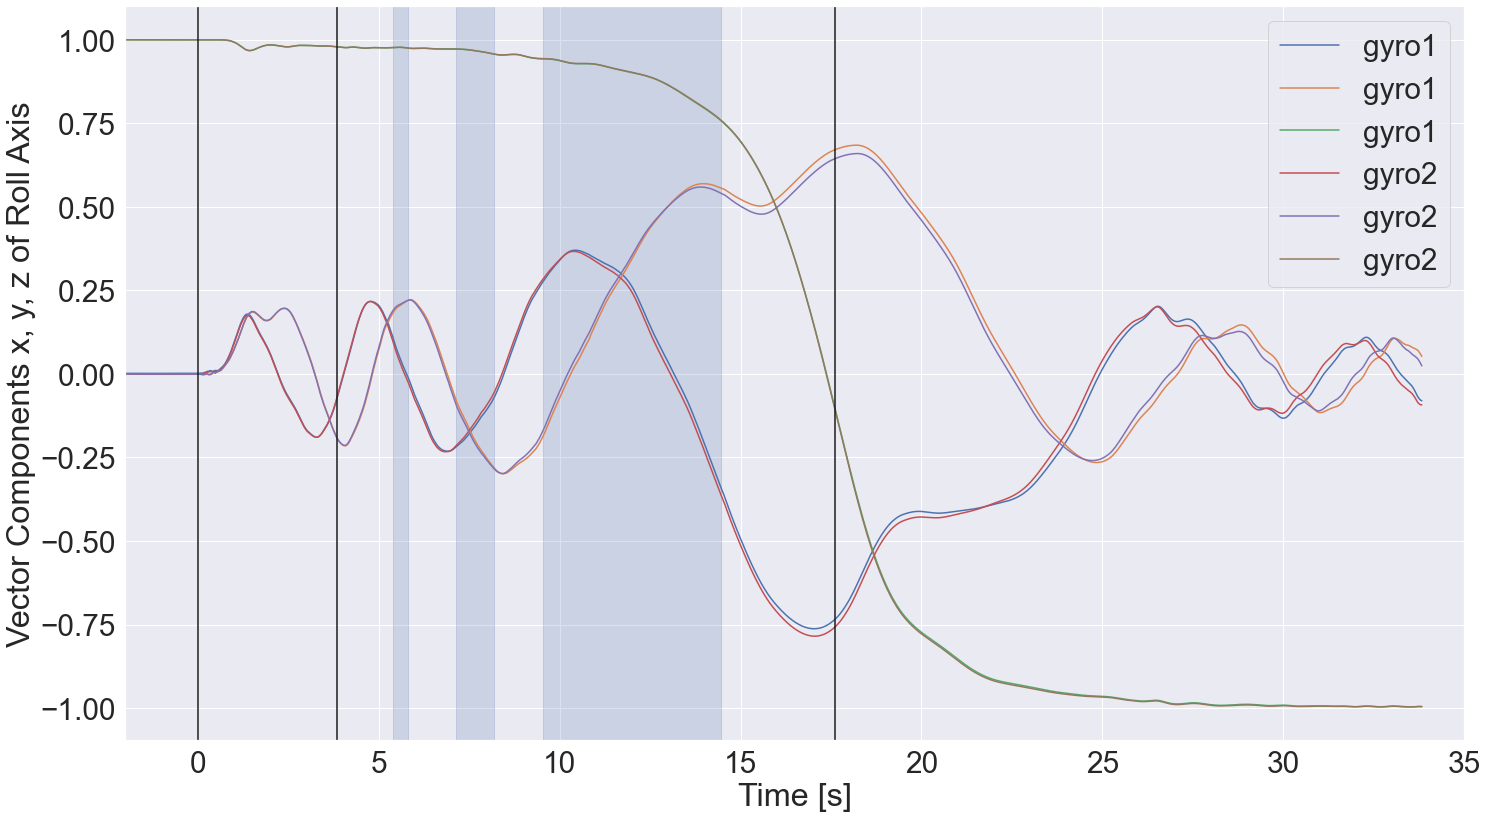

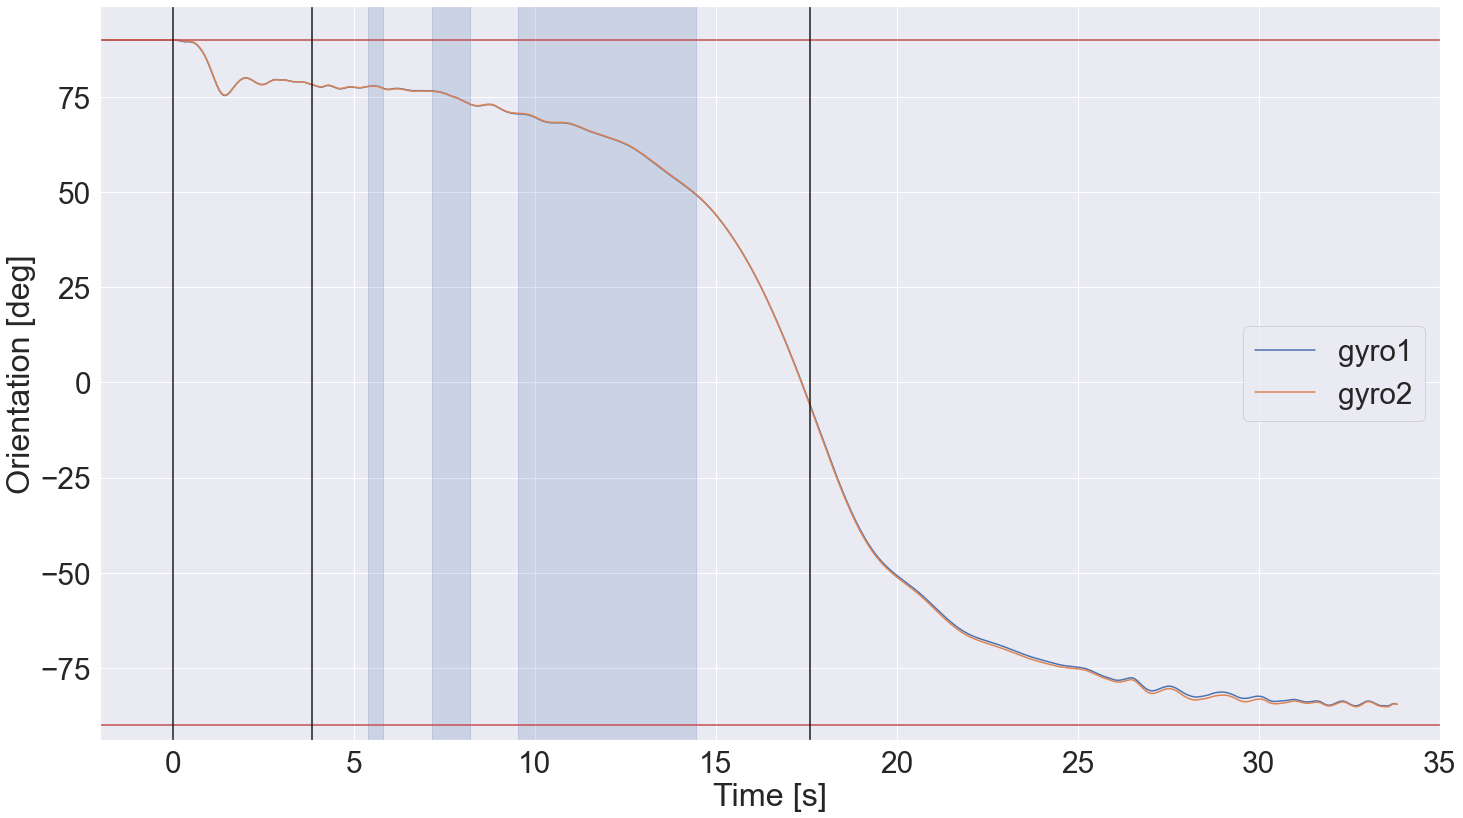

In [5]:
from scipy.spatial.transform import Rotation as R

def compensate_gyro_offset(data, gyro_labels):
    for label in gyro_labels:
        data[label] = data[label] - data[label][combined["Time [s]"]<-0.2].mean()
    return data

def compensate_acc_offset(data, acc_labels):
    for label in acc_labels:
        if label[1]=="y":
            data[label] = data[label] - data[label][combined["Time [s]"]<-0.7].mean() - 9.81
        else:
            data[label] = data[label] - data[label][combined["Time [s]"]<-0.7].mean()
    return data

def get_rotations_from_gyro(t, gyro_x, gyro_y, gyro_z):
    dt_array = np.diff(np.array(t),prepend=0)
    W_gyro = np.array([gyro_x, gyro_y, gyro_z]) / 180*np.pi * dt_array
    dR_array = R.from_rotvec(W_gyro.T)
    return dR_array

def get_orientations_from_rots(R_array):
    RA = np.array([0,0,1])
    rot0 = R.from_euler('yx', [0,0],degrees=True)
    
    RA = rot0.apply(RA)

    
    RA_array = []
    for i in R_array:
        RA = i.apply(RA)
        RA_array.append(RA)
    RA_array = np.array(RA_array)
    return RA_array


def derot_array(array, rot_angle):
    R_derot = R.from_euler("z", rot_angle, degrees=True)
    array_derot = R_derot.apply(array)
    return array_derot

# altitude and hor distance of lr and td (in m)
alt_LR = 1563
pos_LR = 0
alt_TD = 1730
pos_TD = 591

# relative orientaion of rocket (IMU) wrt to horizontal flight path
rot_angel = 28 # degrees

combined = compensate_gyro_offset(combined, gyro_labels)
combined = compensate_acc_offset(combined, acc_labels)

dR_array1 = get_rotations_from_gyro(combined["Time [s]"],combined["Gx_IMU1"],combined["Gz_IMU1"],combined["Gy_IMU1"])
dR_array2 = get_rotations_from_gyro(combined["Time [s]"],combined["Gx_IMU2"],combined["Gz_IMU2"],combined["Gy_IMU2"])

RA_array1  = get_orientations_from_rots(dR_array1)
RA_array2  = get_orientations_from_rots(dR_array2)

RA_array1  = derot_array(RA_array1, rot_angle=28)
RA_array2  = derot_array(RA_array2, rot_angle=28)


plt.plot(combined["Time [s]"], RA_array1, label="gyro1")
plt.plot(combined["Time [s]"], RA_array2, label="gyro2")
plt.xlim(-2, duration)
plt.xlabel("Time [s]")
plt.ylabel("Vector Components x, y, z of Roll Axis")
plt.legend()
plot_events(plt)
plt.show()

def plot_RA_angle(t_array, RA_array, label):
    plt.plot(t_array,90-180/np.pi*np.arccos(RA_array[:,2]), label=label)
    
plot_RA_angle(combined["Time [s]"], RA_array1, "gyro1")
plot_RA_angle(combined["Time [s]"], RA_array2, "gyro2")
plt.xlabel("Time [s]")
plt.ylabel("Orientation [deg]")
plt.axhline(90, color="r")
plt.axhline(-90, color="r")
plt.legend()
plt.xlim(-2, duration)
plot_events(plt)
plt.show()


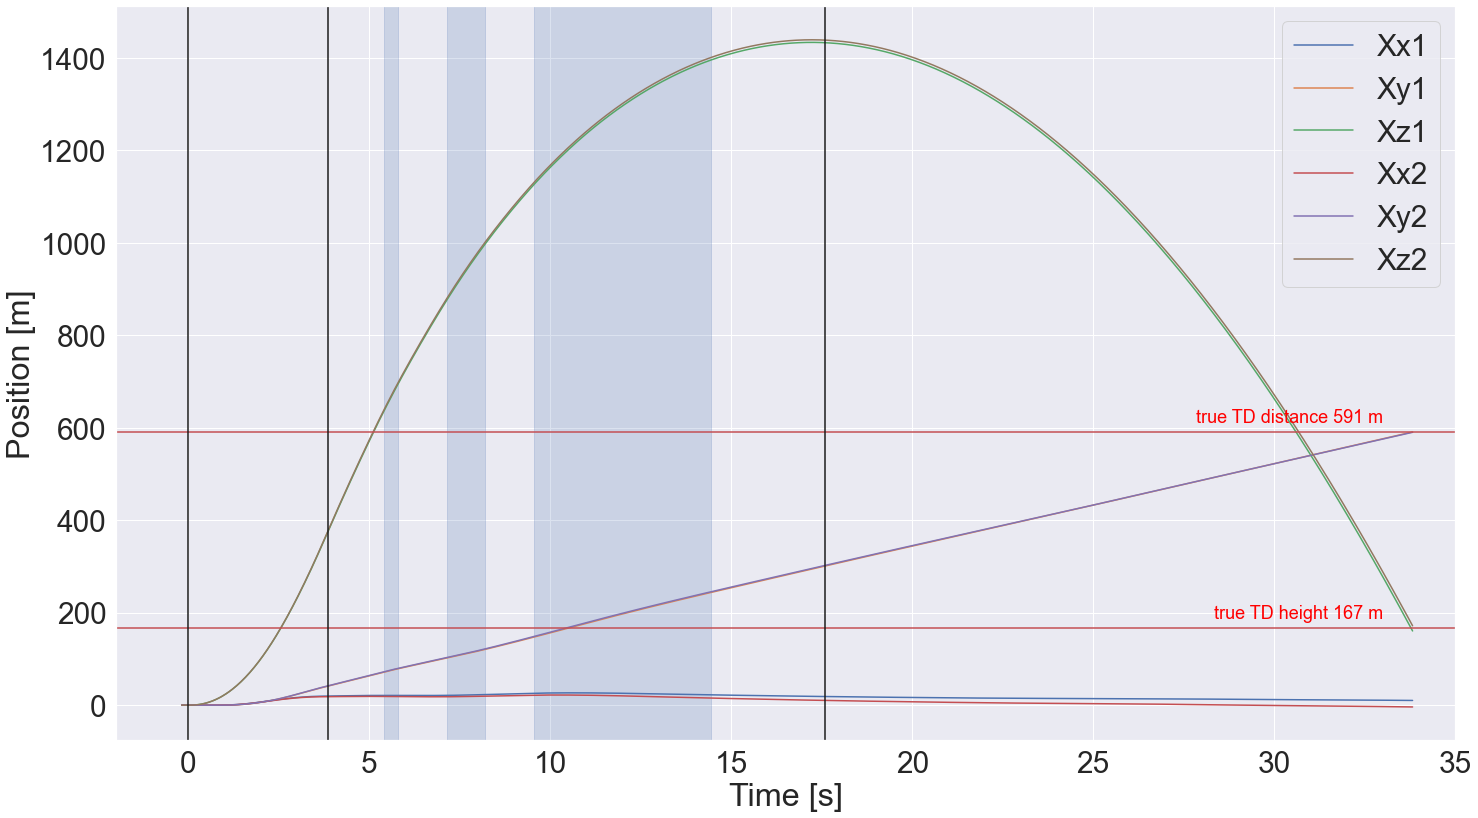

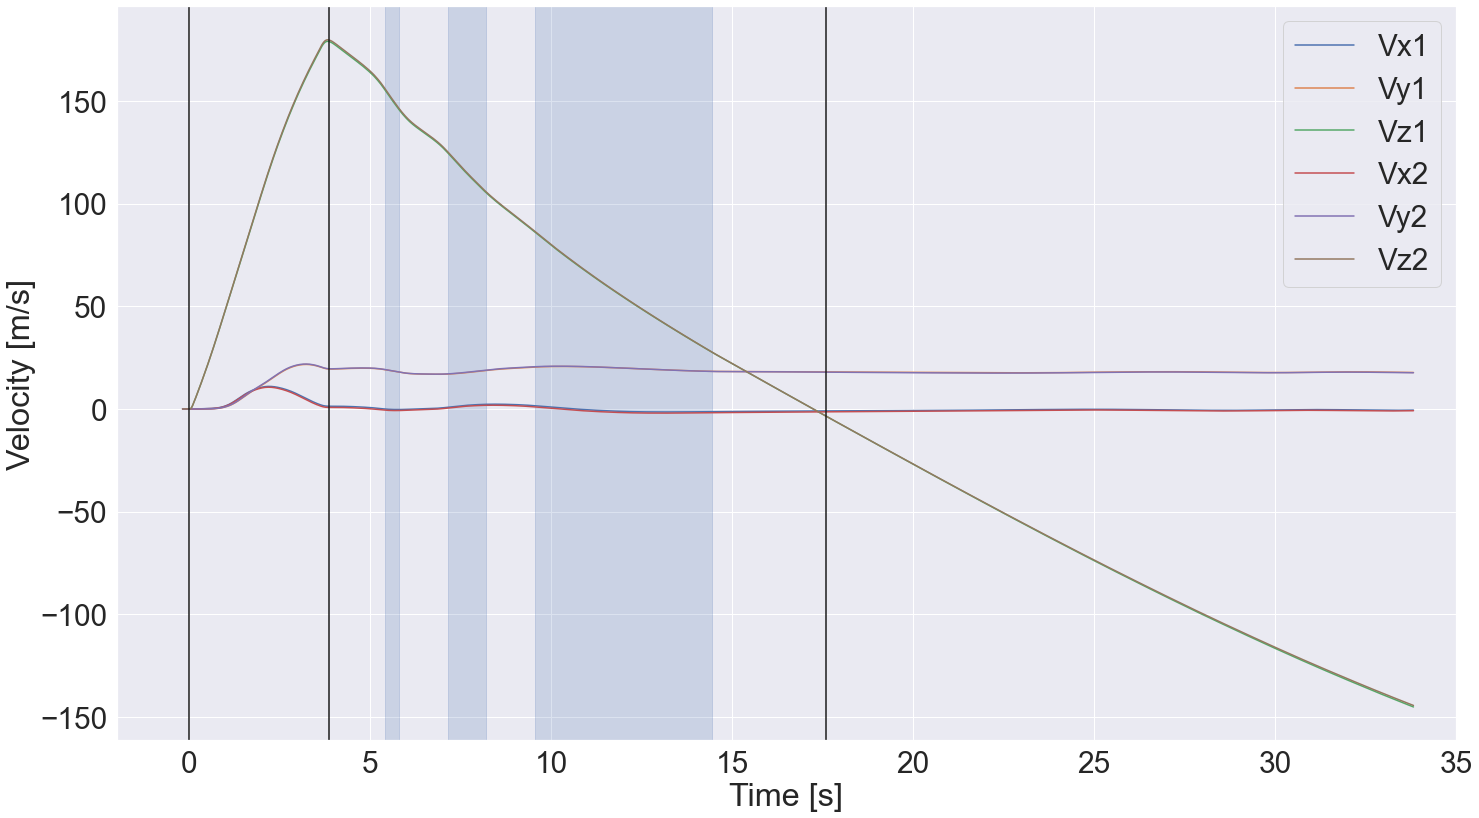

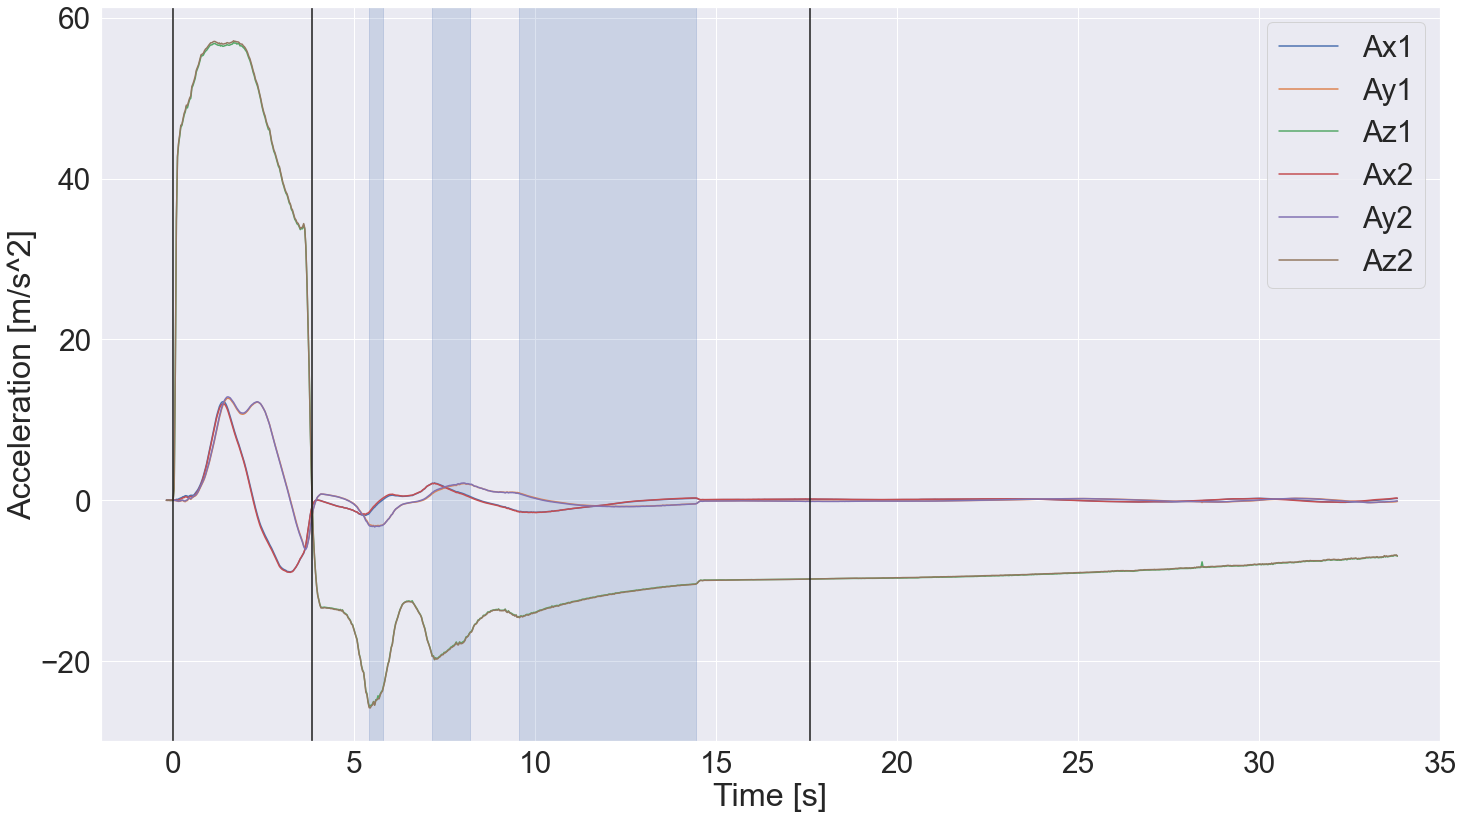

In [6]:
def get_velocity_and_position(t_array, RA_array, a_RA_array):
    cond_launch = t_array>-0.2
    t_array = np.array(t_array[cond_launch])
    RA_array = np.array(RA_array[cond_launch])
    a_RA_array = np.array(a_RA_array[cond_launch])

    n = len(t_array)
    X = np.array([0,0,0]).astype(float)
    V = np.array([0,0,0]).astype(float)
    A = np.array([0,0,0]).astype(float)
    X_array = np.zeros((n,3))
    V_array = np.zeros((n,3))
    A_array = np.zeros((n,3))
    
    dt_array = np.diff(np.array(t_array),prepend=0)
    
    g = 9.81
    A_g = np.array([0,0,-g])
    
    for i in range(len(t_array)):
        A = a_RA_array[i] * RA_array[i] + A_g
        V += A * dt_array[i]
        X += V * dt_array[i]
        
        A_array[i] = A
        V_array[i] = V
        X_array[i] = X
        
    return t_array, X_array, V_array, A_array

a_RA_array1 = -combined["Ay_IMU1"]
a_RA_array2 = -combined["Ay_IMU2"]
t_array, X_array1, V_array1, A_array1 = get_velocity_and_position(combined["Time [s]"], RA_array1, a_RA_array1)
t_array, X_array2, V_array2, A_array2 = get_velocity_and_position(combined["Time [s]"], RA_array2, a_RA_array2)

def plot_3d_array(t_array, array, vector_type):
    comps = ["x","y","z"]
    for i in range(array.shape[1]):
        plt.plot(t_array, array[:,i], label=vector_type[0]+comps[i]+vector_type[-1])
        plt.xlabel("Time [s]")
        

plot_3d_array(t_array, X_array1, vector_type="X1")
plot_3d_array(t_array, X_array2, vector_type="X2")
plt.ylabel("Position [m]")
plt.axhline(alt_TD-alt_LR, color="r")
plt.axhline(pos_TD-pos_LR, color="r")
plt.text(33, pos_TD-pos_LR+20, f"true TD distance {pos_TD-pos_LR:.0f} m", fontsize=18, ha="right", color="red")
plt.text(33, alt_TD-alt_LR+20, f"true TD height {alt_TD-alt_LR:.0f} m", fontsize=18, ha="right", color="red")
plt.legend()
plot_events(plt)
plt.xlim(-2, duration)
plt.show()

plot_3d_array(t_array, V_array1, vector_type="V1")
plot_3d_array(t_array, V_array2, vector_type="V2")
plt.ylabel("Velocity [m/s]")
plt.legend()
plot_events(plt)
plt.xlim(-2, duration)
#plt.xlim(3,5)
#plt.ylim(100,190)


plt.show()


plot_3d_array(t_array, A_array1, vector_type="A1")
plot_3d_array(t_array, A_array2, vector_type="A2")
plt.legend()
plt.ylabel("Acceleration [m/s^2]")
plot_events(plt)
plt.xlim(-2, duration)
#plt.xlim(4,6)

plt.show()



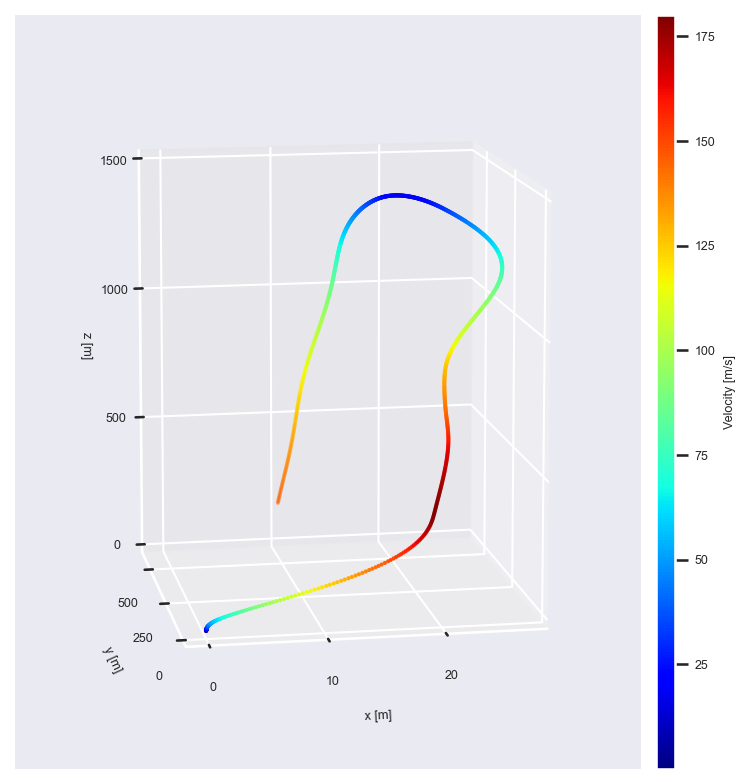

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6), dpi=150)
ax = fig.add_subplot(1,1,1,projection='3d')
ax.view_init(10, -100)


x, y, z = X_array1.T  # transpose and unpack 
V_abs1 = np.sqrt(V_array1[:,0]**2+V_array1[:,1]**2+V_array1[:,2]**2)
V_abs2 = np.sqrt(V_array2[:,0]**2+V_array2[:,1]**2+V_array2[:,2]**2)

p = ax.scatter(x,y,z, c=V_abs1, cmap="jet", s=1)
fontsize=6

def axisEqual3D(ax):
    extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
    sz = extents[:,1] - extents[:,0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize/2
    for ctr, dim in zip(centers, 'xyz'):
        getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)
        
#cmap = plt.cm.viridis()
cbar = fig.colorbar(p, pad=0.02, aspect=40)
cbar.set_label("Velocity [m/s]", size=fontsize)
cbar.ax.tick_params(labelsize=fontsize)

ax.set_xlabel("x [m]", size=fontsize)
ax.set_ylabel("y [m]", size=fontsize)
ax.set_zlabel("z [m]", size=fontsize)

#ax.set_xlim(0,1500)
#ax.set_ylim(0,1500)
ax.set_zlim(0,1500)

for t in ax.xaxis.get_major_ticks(): t.label.set_fontsize(fontsize)
for t in ax.yaxis.get_major_ticks(): t.label.set_fontsize(fontsize)
for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(fontsize)

#axisEqual3D(ax)
plt.tight_layout()
plt.show()

Cd_tot1: 1.7131717816979561 , Cd_tot2: 1.733486675119234 , Mean: 1.723329228408595
Cd_ro1: 0.33337615106670127 , Cd_ro2: 0.34459510321572345 , Mean: 0.3389856271412124


(-2.0, 35.0)

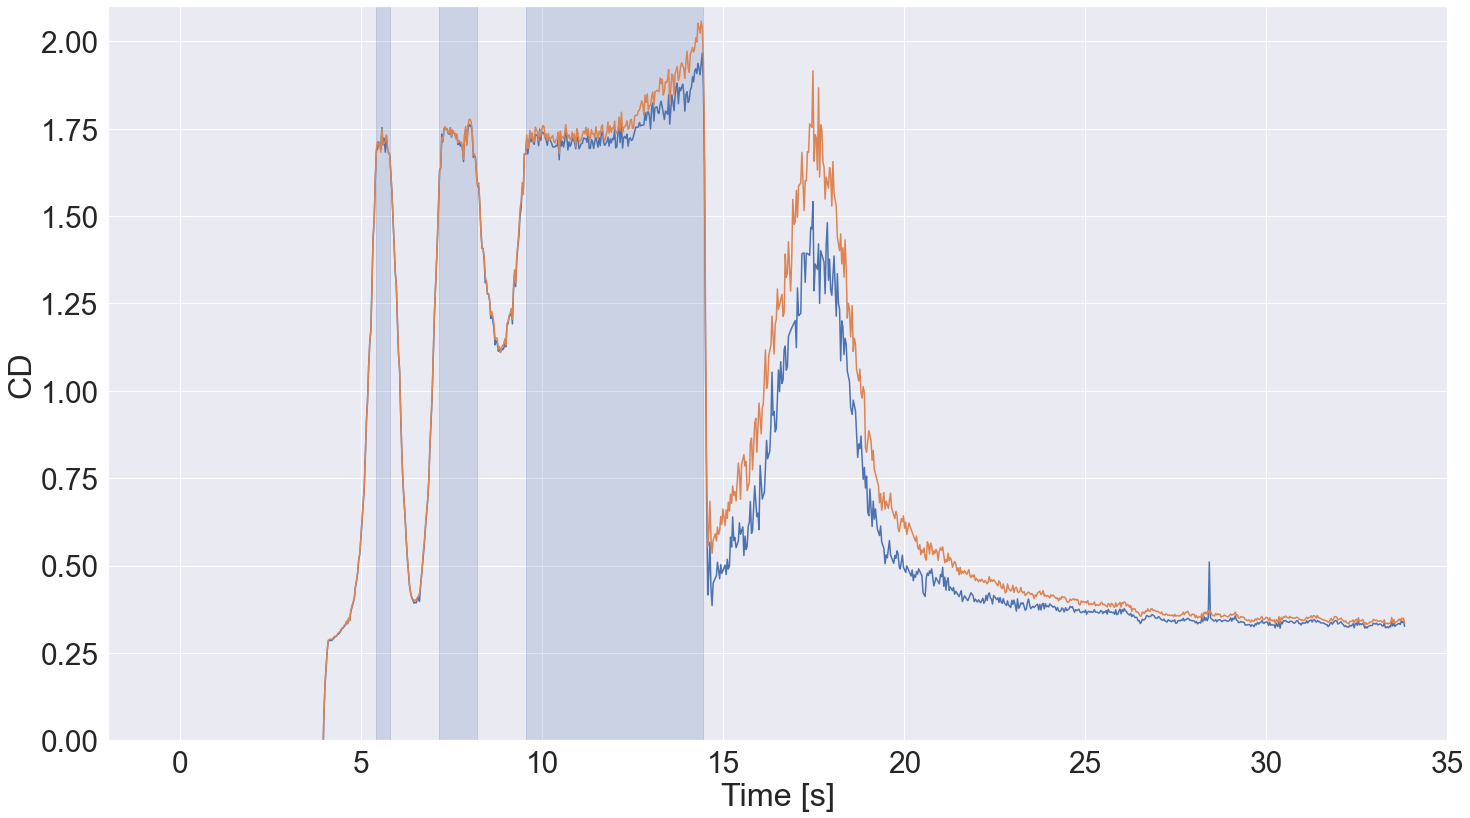

In [8]:
Temp_grad = 0.0065
R_star = 8.3144598
M = 0.0289644
R_const = R_star / M
n = (-g / (Temp_grad * R_const)) - 1
Temp_0 = 273.15
Temp_g = 10
Temp_g = Temp_0 + Temp_g
rho_sea = 1.225
P_sea = 1.01325e5
Temp_sea = 288.15
Pressure_g = 85000
gamma = 1.4

m_empt = 31.5      # kg
A_ref_rocket = np.pi * (0.179/2)**2

def compute_density(alt):
    actual_temp = Temp(alt)
    rho_g = rho_sea * ((Pressure_g / P_sea) * (Temp_sea / Temp_g))
    rho = rho_g * (actual_temp / Temp_g) ** n
    return rho

def Temp(alt):
    T = Temp_g - alt * Temp_grad
    return T


cond_launch = combined["Time [s]"]>-0.2

rho1 = compute_density(X_array1[:,2])
rho2 = compute_density(X_array2[:,2])
F1 = combined['Ay_IMU1'][cond_launch] * m_empt
F2 = combined['Ay_IMU2'][cond_launch] * m_empt
Cd1 = 2*F1 / (V_abs1**2*A_ref_rocket*rho1)
Cd2 = 2*F2 / (V_abs2**2*A_ref_rocket*rho2)


t1=10
t2=12
cond_cd_tot = (t_array>t1)&(t_array<t2)
Cd_tot1 = Cd1[cond_cd_tot].mean()
Cd_tot2 = Cd2[cond_cd_tot].mean()
Cd_tot_mean = 0.5*(Cd_tot1+Cd_tot2)
print("Cd_tot1:", Cd_tot1,", Cd_tot2:", Cd_tot2, ", Mean:", Cd_tot_mean)
#plt.axvline(t1, color="black")
#plt.axvline(t2, color="black")

t3=30
t4=33.5
cond_cd_ro = (t_array>t3)&(t_array<t4)
Cd_ro1 = Cd1[cond_cd_ro].mean()
Cd_ro2 = Cd2[cond_cd_ro].mean()
Cd_ro_mean = 0.5*(Cd_ro1+Cd_ro2)
print("Cd_ro1:", Cd_ro1,", Cd_ro2:", Cd_ro2, ", Mean:", Cd_ro_mean)


plt.plot(combined["Time [s]"][cond_launch], Cd1)
plt.plot(combined["Time [s]"][cond_launch], Cd2)
#plt.axvline(t3, color="black")
#plt.axvline(t4, color="black")
#plt.axhline(Cd_tot_mean, color="red")

plt.ylim(0,2.1)
plt.xlabel("Time [s]")
plt.ylabel("CD")

show_flight_events=False
plot_events(plt)
show_flight_events=True
plt.xlim(-2, duration)






Text(0, 0.5, 'Control input []')

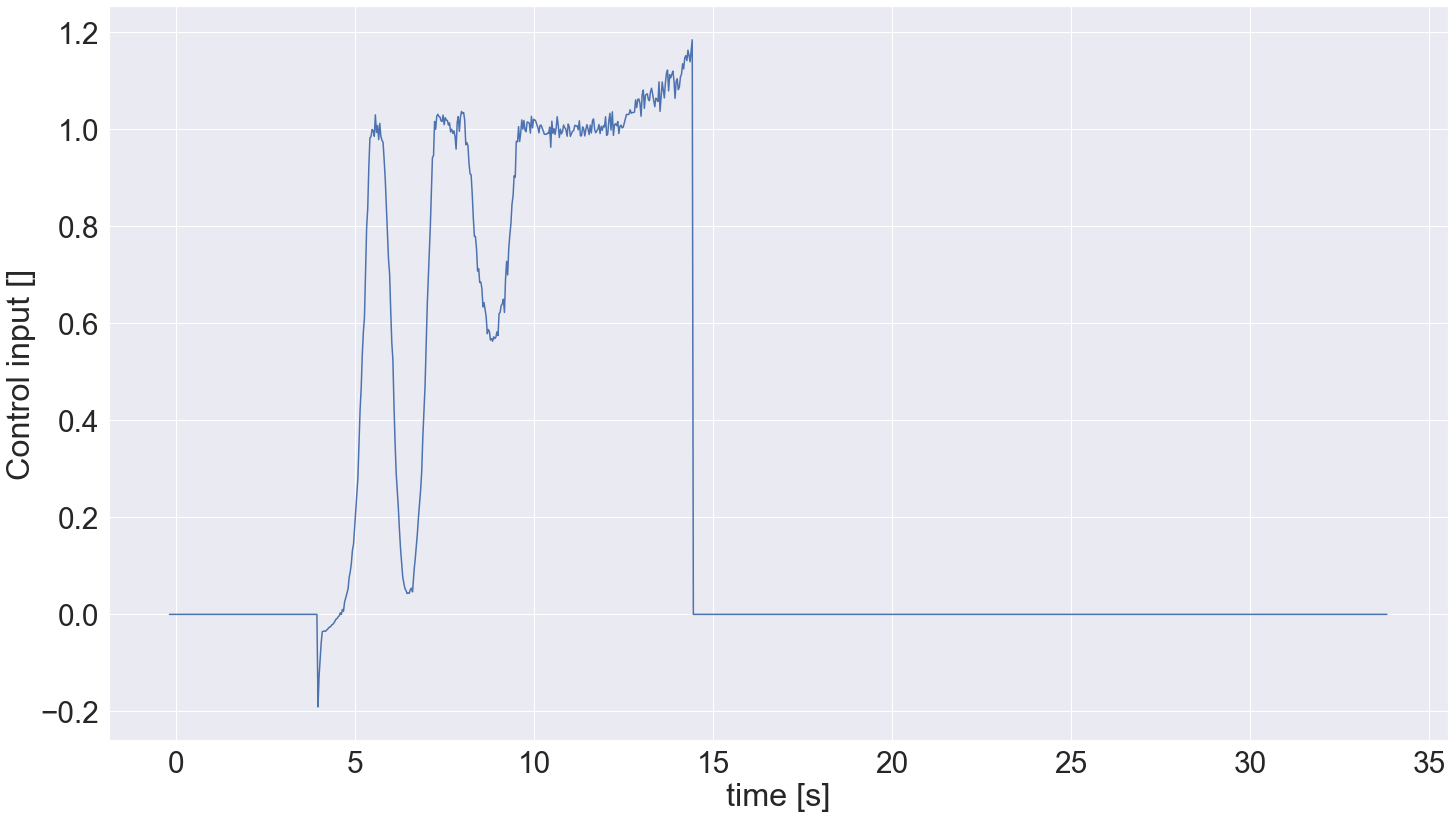

In [9]:
# Control plots

def compute_speed_of_sound(h) -> float:
    C = np.sqrt(gamma * R_const * Temp(h))
    return C

def compute_control_input(acc, vel, alt, t, method='theoretical'):
    if method == 'theoretical':
        n = len(acc)
        control_input = np.zeros(n)
        m_rocket_engineless = 31.5    # kg
        A_ref_rocket = m.pi * (0.179/2)**2

        control_activation_mach_number = 0.55
        control_deactivation_mach_number = 0.1

        for i in range(n):
            speed_of_sound = compute_speed_of_sound(alt[i])
            mach_number = vel[i] / speed_of_sound
            if (control_deactivation_mach_number < mach_number < control_activation_mach_number) and acc[i] > 0 and t_burnout < t[i] < 18:
                rho = compute_density(alt[i])
                control_input[i] = ((acc[i]) * 2 * m_rocket_engineless / (rho * A_ref_rocket * vel[i]**2) - Cd_ro1)/(Cd_tot1 - Cd_ro1)

    else:
        raise Exception('Control input method not defined')

    return control_input

import math as m
# First assumption: cd values known

control_input = compute_control_input(acc=np.array(combined['Ay_IMU1'][cond_launch]), vel=V_abs1, alt=X_array1[: ,2], t = t_array)

plt.plot(t_array, control_input)
plt.xlabel('time [s]')
plt.ylabel('Control input []')


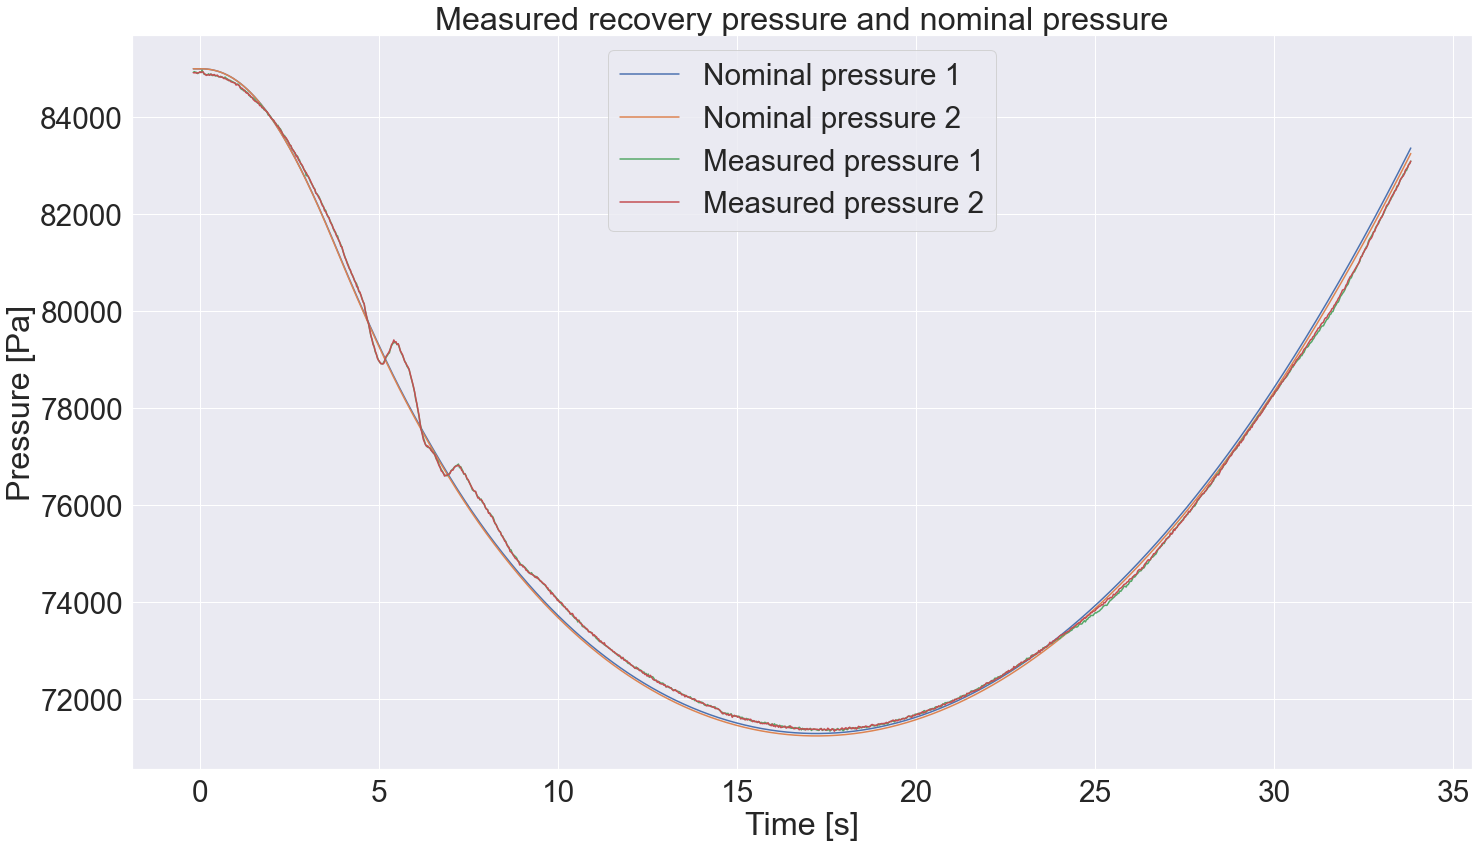

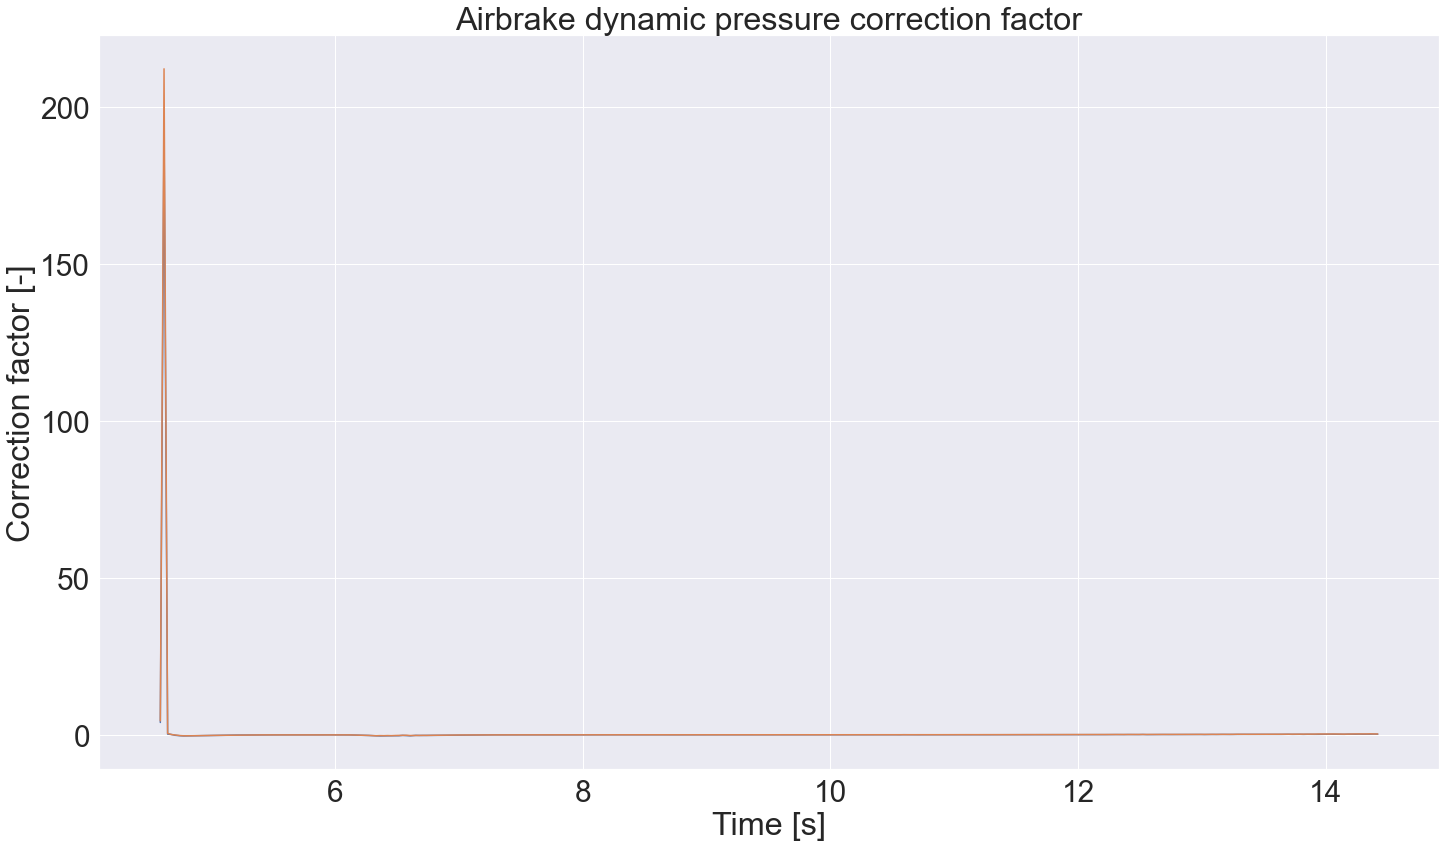

Aibrake dynamic pressure correction factor 1: mean=0.7057042761136259, stdev=10.759138916105567
Aibrake dynamic pressure correction factor 2: mean=0.7870323440490917, stdev=11.790876609413704


In [31]:
def Pressure(h) -> float:
    # input: h = altitude above ground level
    # output: Pressure = pressure
    Pressure = Pressure_g * (Temp(h) / Temp_g) ** ((-g) / (R_const * Temp_grad))
    return Pressure
# analysis of dynamic pressure on barometer measurements
altitude1 = X_array1[:, 2]
altitude2 = X_array2[:, 2]
nominal_pressure1 = Pressure(altitude1)
nominal_pressure2 = Pressure(altitude2)
measured_pressure1 = combined.reset_index()['Pressure 1 [kPa]'][cond_launch]*1000
measured_pressure2 = combined.reset_index()['Pressure 2 [kPa]'][cond_launch]*1000
measured_dynamic_pressure1 = measured_pressure1 - nominal_pressure1
measured_dynamic_pressure2 = measured_pressure2 - nominal_pressure2
dynamic_pressure_norm1 = control_input * rho1 * V_abs1**2 / 2
dynamic_pressure_norm2 = control_input * rho2 * V_abs2**2 / 2
# airbrake dynamic pressure correction factor in recovery section
corr_factor_cond1 = control_input > 0
corr_factor_cond2 = control_input > 0
t_ab_corr_factor1 = combined["Time [s]"][cond_launch][corr_factor_cond1]
t_ab_corr_factor2 = combined["Time [s]"][cond_launch][corr_factor_cond2]
ab_dp_corr_factor1 = measured_dynamic_pressure1[corr_factor_cond1] / dynamic_pressure_norm1[corr_factor_cond1]
ab_dp_corr_factor2 = measured_dynamic_pressure2[corr_factor_cond2] / dynamic_pressure_norm2[corr_factor_cond2]

plt.plot(combined["Time [s]"][cond_launch], nominal_pressure1)
plt.plot(combined["Time [s]"][cond_launch], nominal_pressure2)
plt.plot(combined["Time [s]"][cond_launch], measured_pressure1)
plt.plot(combined["Time [s]"][cond_launch], measured_pressure2)
plt.title("Measured recovery pressure and nominal pressure")
plt.legend(["Nominal pressure 1", "Nominal pressure 2", "Measured pressure 1", "Measured pressure 2"])
plt.xlabel("Time [s]")
plt.ylabel("Pressure [Pa]")
plt.show()

plt.plot(t_ab_corr_factor1, ab_dp_corr_factor1)
plt.plot(t_ab_corr_factor2, ab_dp_corr_factor2)
plt.title("Airbrake dynamic pressure correction factor")
plt.xlabel("Time [s]")
plt.ylabel("Correction factor [-]")
plt.show()

ab_dp_corr_factor1_mean, ab_dp_corr_factor1_stdev = np.mean(ab_dp_corr_factor1), np.std(ab_dp_corr_factor1)
ab_dp_corr_factor2_mean, ab_dp_corr_factor2_stdev = np.mean(ab_dp_corr_factor2), np.std(ab_dp_corr_factor2)
print(f"Aibrake dynamic pressure correction factor 1: mean={ab_dp_corr_factor1_mean}, stdev={ab_dp_corr_factor1_stdev}")
print(f"Aibrake dynamic pressure correction factor 2: mean={ab_dp_corr_factor2_mean}, stdev={ab_dp_corr_factor2_stdev}")

(1120,)


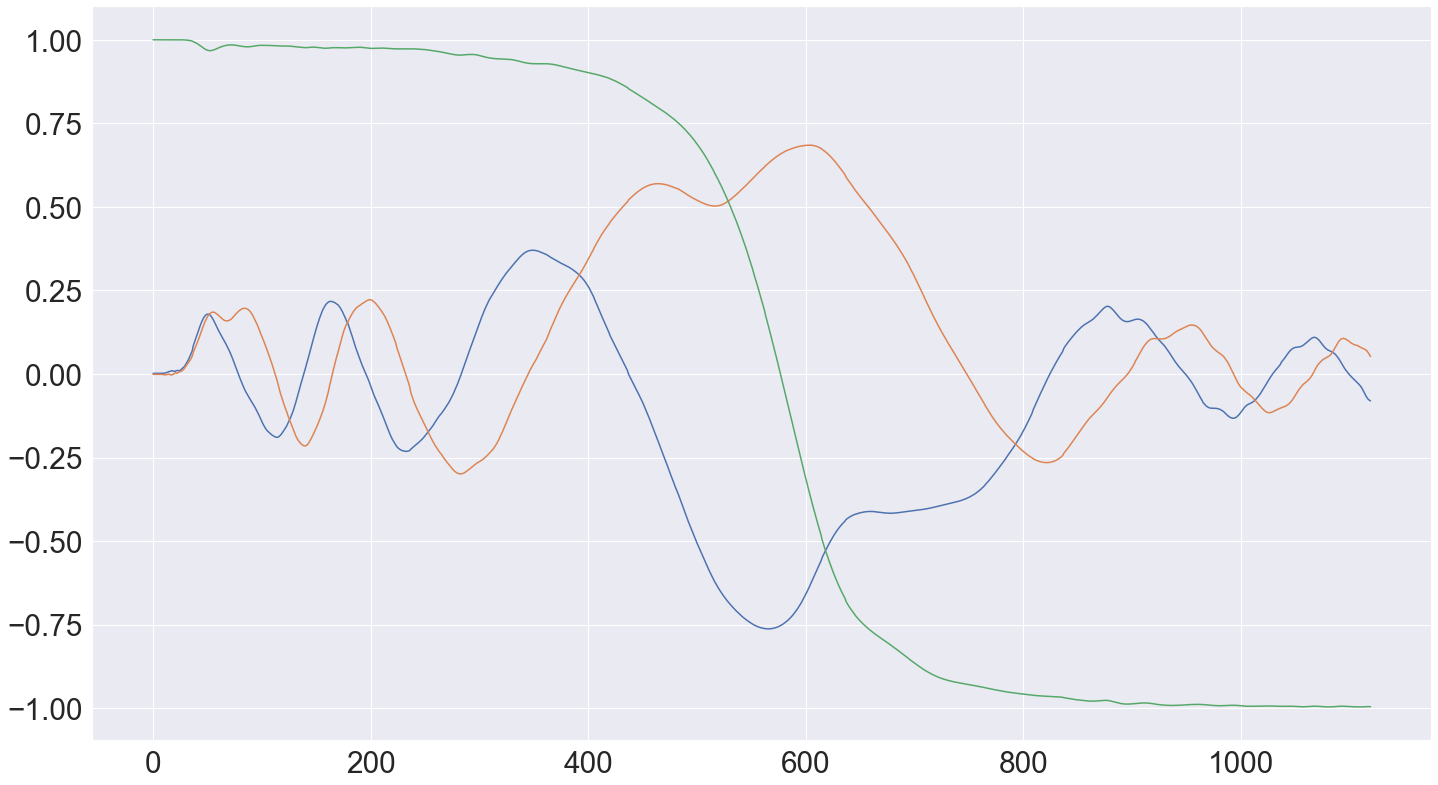

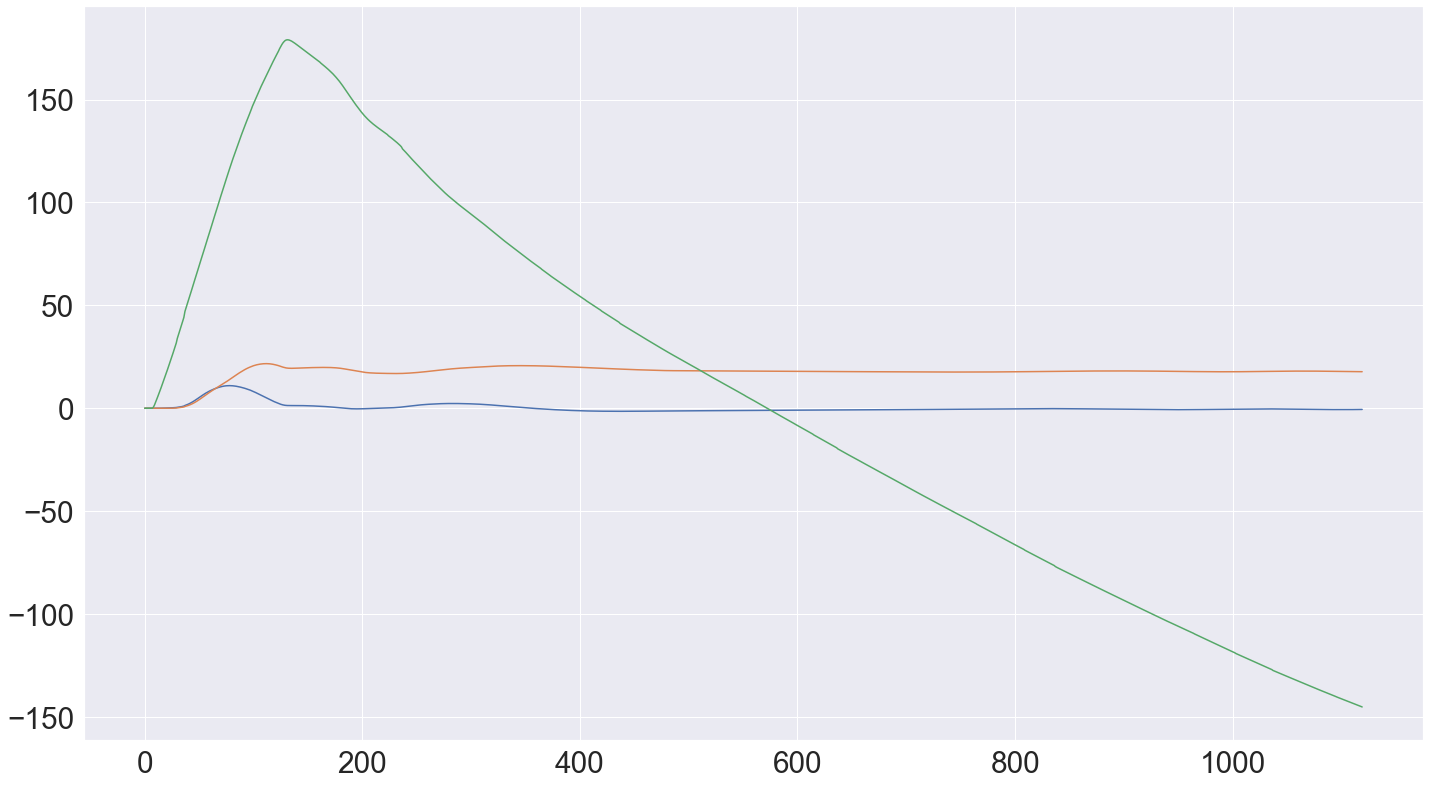

In [19]:
def get_abs(A):
    abs_a = np.sqrt(A[:,0]**2+A[:,1]**2+A[:,2]**2)
    return abs_a

def get_angle(A,B):
    dot = np.array([np.dot(A[i], B[i]) for i in range(A.shape[0])])
    abs_a = get_abs(A)
    abs_b = get_abs(B)
    print(abs_a.shape)
    angle = np.arccos(dot / abs_a /abs_b)
    return angle
    
angle = get_angle(RA_array1[cond_launch], V_array1) * 180/np.pi
abs_RA = get_abs(RA_array1[cond_launch])
plt.plot(RA_array1[cond_launch])
plt.show()
plt.plot(V_array1)


In [ ]:
'''
import image
import imageio
from mayavi import mlab
mlab.options.offscreen = False
from tvtk.api import tvtk
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import numpy as np
%gui qt


im=imageio.imread('dhm25_dhm25.tif')
im=np.rot90(im,k=3)

im1 = imageio.imread("swissimage1m_latest.tif")
#im1=np.swapaxes(im1,0,1)
im1=np.rot90(im1,k=4)

#surface plotting test
imageio.imwrite("swissimage1m_latest.jpg", im1[:,:,:3])
mlab.figure(size=(1000, 1000), bgcolor=(0.16, 0.28, 0.46))
mlab.surf(im, warp_scale=0.05) 
mlab.show()
'''



In [ ]:
# trajectory plotting test
'''
bmp1 = tvtk.JPEGReader()
bmp1.file_name="swissimage_latest.jpg" #any jpeg file

texture = tvtk.Texture(input_connection=bmp1.output_port, interpolate=0)

vert_factor = 20
X_plot = derot_array(X_array1, 133)
x, y, z = X_plot.T / 25# transpose and unpack 
v_abs1 = np.sqrt(V_array1[:,0]**2+V_array1[:,1]**2+V_array1[:,2]**2)

x0= 1535/25 - 50
y0= 1520/25 - 50 
z0= 1563/vert_factor

mlab.figure(size=(1000, 1000), bgcolor=(0.16, 0.28, 0.46))

surf = mlab.surf(im, color=(1,1,1),warp_scale=1./vert_factor) 
surf.actor.enable_texture = True
surf.actor.tcoord_generator_mode = 'plane'
surf.actor.actor.texture = texture
mlab.axes()

line=mlab.plot3d(x+x0, y+y0, z+z0, v_abs1, tube_radius=0.2)
mlab.view(135, 70)
mlab.view(distance=130)


mlab.savefig('example.png')
'''

In [ ]:
# animation
'''
import os
from scipy.spatial.transform import Rotation as R

bmp1 = tvtk.JPEGReader()
bmp1.file_name="swissimage_latest.jpg" #any jpeg file

texture = tvtk.Texture(input_connection=bmp1.output_port, interpolate=0)

vert_factor = 25
X_plot = derot_array(X_array1, 133)
x, y, z = X_plot.T / 25# transpose and unpack 
v_abs1 = np.sqrt(V_array1[:,0]**2+V_array1[:,1]**2+V_array1[:,2]**2)

x0= 1535/25 - 50
y0= 1520/25 - 50 
z0= 1568/vert_factor

f=mlab.figure(size=(1500, 1000), bgcolor=(0.0, 0.3, 0.6))
#f.scene.movie_maker.record = True

surf = mlab.surf(im, color=(1,1,1),warp_scale=1./vert_factor) 
surf.actor.enable_texture = True
surf.actor.tcoord_generator_mode = 'plane'
surf.actor.actor.texture = texture
#mlab.axes()

mlab.view(135, 65)
mlab.view(distance=130)

line=mlab.plot3d(x[0]+x0, y[0]+y0, z[0]+z0, v_abs1[0], tube_radius=0.2, colormap="YlOrRd")

az_init=95
mlab.view(az_init, 70)

fig = mlab.gcf()
ms = line.mlab_source


# Output path for you animation images
out_path = './animation2/'
out_path = os.path.abspath(out_path)
prefix = 'ani'
ext = '.png'
padding = len(str(len(x)))


step_size=4
n_steps = int(X_plot.shape[0]/step_size)
delay = int(35000/n_steps / 2) 
@mlab.animate(delay=10, ui=False)
def anim():
    for i in range(n_steps):
        xnew, ynew, znew = X_plot[:(i+1)*step_size].T / 25# transpose and unpack 
        vnew = v_abs1[:(i+1)*step_size]
        ms.reset(x=xnew+x0, y=ynew+y0, z=znew+z0, scalars=vnew)
        #mlab.view(135, 70)
        mlab.view(az_init+i/n_steps*50, 70)

        mlab.view(distance=np.maximum(30,znew.max()*2),
                  focalpoint=((xnew.mean()+x0),
                              (ynew.mean()+y0),
                              (znew.max()/1.8+z0)))
        
        # create zeros for padding index positions for organization
        zeros = '0'*(padding - len(str(i)))
        # concate filename with zero padded index number as suffix
        filename = os.path.join(out_path, 'ani_'+str(zeros)+str(i)+".png")
        #mlab.savefig(filename=filename)
        yield

a=anim()

'''

In [ ]:
# pngs to movie
'''
import cv2
import os

image_folder = 'animation'
video_name = 'ML_animation_hq_landscape.mp4'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

# commented out to prevent unwanted video generation
#video = cv2.VideoWriter(video_name, 0, fps=int(1000/delay), frameSize=(width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()
'''

In [ ]:
'''
import image
import imageio
from mayavi import mlab
mlab.options.offscreen = False
from tvtk.api import tvtk
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import numpy as np
%gui qt


im=imageio.imread('dhm25_dhm25.tif')
im=np.rot90(im,k=3)

im1 = imageio.imread("swissimage1m_latest.tif")
#im1=np.swapaxes(im1,0,1)
im1=np.rot90(im1,k=4)

#surface plotting test
imageio.imwrite("swissimage1m_latest.jpg", im1[:,:,:3])
mlab.figure(size=(1000, 1000), bgcolor=(0.16, 0.28, 0.46))
mlab.surf(im, warp_scale=0.05) 
mlab.show()
'''



In [ ]:
# trajectory plotting test
'''
bmp1 = tvtk.JPEGReader()
bmp1.file_name="swissimage_latest.jpg" #any jpeg file

texture = tvtk.Texture(input_connection=bmp1.output_port, interpolate=0)

vert_factor = 20
X_plot = derot_array(X_array1, 133)
x, y, z = X_plot.T / 25# transpose and unpack 
v_abs1 = np.sqrt(V_array1[:,0]**2+V_array1[:,1]**2+V_array1[:,2]**2)

x0= 1535/25 - 50
y0= 1520/25 - 50 
z0= 1563/vert_factor

mlab.figure(size=(1000, 1000), bgcolor=(0.16, 0.28, 0.46))

surf = mlab.surf(im, color=(1,1,1),warp_scale=1./vert_factor) 
surf.actor.enable_texture = True
surf.actor.tcoord_generator_mode = 'plane'
surf.actor.actor.texture = texture
mlab.axes()

line=mlab.plot3d(x+x0, y+y0, z+z0, v_abs1, tube_radius=0.2)
mlab.view(135, 70)
mlab.view(distance=130)


mlab.savefig('example.png')
'''

In [ ]:
# animation
'''
import os
from scipy.spatial.transform import Rotation as R

bmp1 = tvtk.JPEGReader()
bmp1.file_name="swissimage_latest.jpg" #any jpeg file

texture = tvtk.Texture(input_connection=bmp1.output_port, interpolate=0)

vert_factor = 25
X_plot = derot_array(X_array1, 133)
x, y, z = X_plot.T / 25# transpose and unpack 
v_abs1 = np.sqrt(V_array1[:,0]**2+V_array1[:,1]**2+V_array1[:,2]**2)

x0= 1535/25 - 50
y0= 1520/25 - 50 
z0= 1568/vert_factor

f=mlab.figure(size=(1500, 1000), bgcolor=(0.0, 0.3, 0.6))
#f.scene.movie_maker.record = True

surf = mlab.surf(im, color=(1,1,1),warp_scale=1./vert_factor) 
surf.actor.enable_texture = True
surf.actor.tcoord_generator_mode = 'plane'
surf.actor.actor.texture = texture
#mlab.axes()

mlab.view(135, 65)
mlab.view(distance=130)

line=mlab.plot3d(x[0]+x0, y[0]+y0, z[0]+z0, v_abs1[0], tube_radius=0.2, colormap="YlOrRd")

az_init=95
mlab.view(az_init, 70)

fig = mlab.gcf()
ms = line.mlab_source


# Output path for you animation images
out_path = './animation2/'
out_path = os.path.abspath(out_path)
prefix = 'ani'
ext = '.png'
padding = len(str(len(x)))


step_size=4
n_steps = int(X_plot.shape[0]/step_size)
delay = int(35000/n_steps / 2) 
@mlab.animate(delay=10, ui=False)
def anim():
    for i in range(n_steps):
        xnew, ynew, znew = X_plot[:(i+1)*step_size].T / 25# transpose and unpack 
        vnew = v_abs1[:(i+1)*step_size]
        ms.reset(x=xnew+x0, y=ynew+y0, z=znew+z0, scalars=vnew)
        #mlab.view(135, 70)
        mlab.view(az_init+i/n_steps*50, 70)

        mlab.view(distance=np.maximum(30,znew.max()*2),
                  focalpoint=((xnew.mean()+x0),
                              (ynew.mean()+y0),
                              (znew.max()/1.8+z0)))
        
        # create zeros for padding index positions for organization
        zeros = '0'*(padding - len(str(i)))
        # concate filename with zero padded index number as suffix
        filename = os.path.join(out_path, 'ani_'+str(zeros)+str(i)+".png")
        #mlab.savefig(filename=filename)
        yield

a=anim()
'''


In [ ]:
# pngs to movie
'''
import cv2
import os

image_folder = 'animation'
video_name = 'ML_animation_hq_landscape.mp4'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

# commented out to prevent unwanted video generation
#video = cv2.VideoWriter(video_name, 0, fps=int(1000/delay), frameSize=(width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()
'''